# UIUC Data Set Dimensionality Study

In [9]:
#imports and loads

import seaborn as sns
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


non_opt_coor = np.load('airfoil_interp_192.npy')

cor = np.arange(0,384,1)
df = pd.DataFrame(non_opt_coor.reshape(1528,384), columns = [cor])


#Scaling
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
scaleddf = pd.DataFrame(scaled, columns = [cor])

#Use GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

num = 25
comp = 4
test_size = 0.2
train_size = (1-test_size)*1528
ts = 1528 - train_size
X_train = np.zeros((num, int(test_size),384), dtype=float)
X_test = np.zeros((num, int(ts), 384), dtype=float)


           0             1         2         3         4         5    \
0     1.000036  8.064233e-05  0.991114  0.003846  0.981408  0.007491   
1     0.999999  7.461522e-04  0.988823  0.002855  0.977597  0.005032   
2     1.000016  1.024343e-03  0.988768  0.003418  0.977520  0.005786   
3     1.000000  1.143125e-03  0.990472  0.004639  0.980731  0.007854   
4     1.000000  1.563698e-07  0.989637  0.001866  0.979216  0.004000   
...        ...           ...       ...       ...       ...       ...   
1523  1.000000 -1.154414e-04  0.989019  0.001490  0.978027  0.003219   
1524  1.000001  4.001617e-03  0.989927  0.006687  0.979691  0.009162   
1525  1.000023  3.743312e-04  0.988636  0.001654  0.977245  0.002952   
1526  0.999996 -1.402378e-03  0.988798  0.001732  0.977559  0.004791   
1527  1.000044  1.154443e-04  0.990690  0.003068  0.980752  0.005844   

           6         7         8         9    ...       374       375  \
0     0.970802  0.011178  0.959717  0.014961  ...  0.957676  0

In [10]:
class Autoencoder(nn.Module):
    """Makes the main denoising auto

    Parameters
    ----------
    in_shape [int] : input shape
    enc_shape [int] : desired encoded shape
    """

    def __init__(self, in_shape, enc_shape):
        super(Autoencoder, self).__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(in_shape, 384),
            nn.ReLU(True),
            nn.Linear(384, enc_shape),
        )
        
        self.decode = nn.Sequential(
            nn.BatchNorm1d(enc_shape),
            nn.Linear(enc_shape, 384),
            nn.ReLU(True),
            nn.Linear(384, in_shape)
        )
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [11]:
def train(model, error, optimizer, n_epochs, x):
    model.train()
    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()
        output = model(x)
        error = nn.MSELoss()
        loss = error(output, x)
        loss.backward()
        optimizer.step()
        
        if epoch % int(0.05*n_epochs) == 0:
            print(f'epoch {epoch} \t Loss: {loss.item():.4g}')

In [12]:

import math
num = 25
dim = 20
MSE_TRAIN = np.zeros((dim, num), dtype=float)
MSE_TEST = np.zeros((dim, num), dtype=float)
RE = np.zeros((dim, num, math.ceil(ts)), dtype=float)
output = np.zeros((dim, num, int(train_size),384), dtype=float)
output_y = np.zeros((dim, num, math.ceil(ts),384), dtype=float)


def complete_train_test(n_epochs, scaled, num):
    for i in range(1,dim+1):
        encoder = Autoencoder(in_shape=384, enc_shape=i).double().to(device)
        error = nn.MSELoss()
        learning_rate = 0.0001
        optimizer = optim.Adam(encoder.parameters(),lr=learning_rate, weight_decay=0)
    
        for j in range(num):
            x, y = train_test_split(scaled, test_size=test_size, shuffle=True)
            train(encoder, error, optimizer, n_epochs, torch.from_numpy(x).to(device))
        
            output[i-1][j] = encoder(torch.from_numpy(x).to(device)).detach().cpu().numpy()
            output_y[i-1][j] = encoder(torch.from_numpy(y).to(device)).detach().cpu().numpy()
            
            MSE_TRAIN[i-1][j] = mean_squared_error(x, output[i-1][j])
            MSE_TEST[i-1][j] = mean_squared_error(y, output_y[i-1][j])
            
            RE[i-1][j] = ((output_y[i-1][j] - y)**2).mean(axis=1)
            print(f'\nLatent Space Size: {i}   \nIteration: {j}')
    print(f'\nMSE TEST: {MSE_TEST} \nMSE TRAIN: {MSE_TRAIN}\n\n')

In [13]:
%%time
complete_train_test(1000, scaled, num)
#Assumes the learning rate is constant

epoch 50 	 Loss: 0.07747
epoch 100 	 Loss: 0.01722
epoch 150 	 Loss: 0.009304
epoch 200 	 Loss: 0.009458
epoch 250 	 Loss: 0.007013
epoch 300 	 Loss: 0.00659
epoch 350 	 Loss: 0.006473
epoch 400 	 Loss: 0.006209
epoch 450 	 Loss: 0.005936
epoch 500 	 Loss: 0.005746
epoch 550 	 Loss: 0.005572
epoch 600 	 Loss: 0.005408
epoch 650 	 Loss: 0.005423
epoch 700 	 Loss: 0.005135
epoch 750 	 Loss: 0.005057
epoch 800 	 Loss: 0.004881
epoch 850 	 Loss: 0.004986
epoch 900 	 Loss: 0.004753
epoch 950 	 Loss: 0.004639
epoch 1000 	 Loss: 0.004558

Latent Space Size: 1   
Iteration: 0
epoch 50 	 Loss: 0.004655
epoch 100 	 Loss: 0.004507
epoch 150 	 Loss: 0.004473
epoch 200 	 Loss: 0.004425
epoch 250 	 Loss: 0.004435
epoch 300 	 Loss: 0.004375
epoch 350 	 Loss: 0.004345
epoch 400 	 Loss: 0.004278
epoch 450 	 Loss: 0.004254
epoch 500 	 Loss: 0.004226
epoch 550 	 Loss: 0.004261
epoch 600 	 Loss: 0.004169
epoch 650 	 Loss: 0.004204
epoch 700 	 Loss: 0.004155
epoch 750 	 Loss: 0.004187
epoch 800 	 Loss: 0.0

epoch 300 	 Loss: 0.003228
epoch 350 	 Loss: 0.003295
epoch 400 	 Loss: 0.003303
epoch 450 	 Loss: 0.003248
epoch 500 	 Loss: 0.003227
epoch 550 	 Loss: 0.003214
epoch 600 	 Loss: 0.003573
epoch 650 	 Loss: 0.003293
epoch 700 	 Loss: 0.003263
epoch 750 	 Loss: 0.003309
epoch 800 	 Loss: 0.003234
epoch 850 	 Loss: 0.003145
epoch 900 	 Loss: 0.003298
epoch 950 	 Loss: 0.003345
epoch 1000 	 Loss: 0.00326

Latent Space Size: 1   
Iteration: 14
epoch 50 	 Loss: 0.003269
epoch 100 	 Loss: 0.003197
epoch 150 	 Loss: 0.003416
epoch 200 	 Loss: 0.003561
epoch 250 	 Loss: 0.003675
epoch 300 	 Loss: 0.003441
epoch 350 	 Loss: 0.003497
epoch 400 	 Loss: 0.003171
epoch 450 	 Loss: 0.003508
epoch 500 	 Loss: 0.003148
epoch 550 	 Loss: 0.00318
epoch 600 	 Loss: 0.003517
epoch 650 	 Loss: 0.003246
epoch 700 	 Loss: 0.003445
epoch 750 	 Loss: 0.003175
epoch 800 	 Loss: 0.003319
epoch 850 	 Loss: 0.003493
epoch 900 	 Loss: 0.003135
epoch 950 	 Loss: 0.003194
epoch 1000 	 Loss: 0.003585

Latent Space Siz

epoch 550 	 Loss: 0.002089
epoch 600 	 Loss: 0.002021
epoch 650 	 Loss: 0.002053
epoch 700 	 Loss: 0.00201
epoch 750 	 Loss: 0.002023
epoch 800 	 Loss: 0.002003
epoch 850 	 Loss: 0.001951
epoch 900 	 Loss: 0.002036
epoch 950 	 Loss: 0.001938
epoch 1000 	 Loss: 0.001936

Latent Space Size: 2   
Iteration: 3
epoch 50 	 Loss: 0.001972
epoch 100 	 Loss: 0.001971
epoch 150 	 Loss: 0.001978
epoch 200 	 Loss: 0.001985
epoch 250 	 Loss: 0.001902
epoch 300 	 Loss: 0.00191
epoch 350 	 Loss: 0.001893
epoch 400 	 Loss: 0.001899
epoch 450 	 Loss: 0.001857
epoch 500 	 Loss: 0.001902
epoch 550 	 Loss: 0.001891
epoch 600 	 Loss: 0.001884
epoch 650 	 Loss: 0.001881
epoch 700 	 Loss: 0.001877
epoch 750 	 Loss: 0.001874
epoch 800 	 Loss: 0.001819
epoch 850 	 Loss: 0.001872
epoch 900 	 Loss: 0.001838
epoch 950 	 Loss: 0.001851
epoch 1000 	 Loss: 0.001794

Latent Space Size: 2   
Iteration: 4
epoch 50 	 Loss: 0.001761
epoch 100 	 Loss: 0.001729
epoch 150 	 Loss: 0.001745
epoch 200 	 Loss: 0.001736
epoch 25

epoch 800 	 Loss: 0.00135
epoch 850 	 Loss: 0.001286
epoch 900 	 Loss: 0.001338
epoch 950 	 Loss: 0.001257
epoch 1000 	 Loss: 0.00124

Latent Space Size: 2   
Iteration: 17
epoch 50 	 Loss: 0.001213
epoch 100 	 Loss: 0.001242
epoch 150 	 Loss: 0.001199
epoch 200 	 Loss: 0.001201
epoch 250 	 Loss: 0.001214
epoch 300 	 Loss: 0.001202
epoch 350 	 Loss: 0.001189
epoch 400 	 Loss: 0.001198
epoch 450 	 Loss: 0.001203
epoch 500 	 Loss: 0.001227
epoch 550 	 Loss: 0.001196
epoch 600 	 Loss: 0.001233
epoch 650 	 Loss: 0.001188
epoch 700 	 Loss: 0.001246
epoch 750 	 Loss: 0.001204
epoch 800 	 Loss: 0.001175
epoch 850 	 Loss: 0.001196
epoch 900 	 Loss: 0.001223
epoch 950 	 Loss: 0.001168
epoch 1000 	 Loss: 0.001196

Latent Space Size: 2   
Iteration: 18
epoch 50 	 Loss: 0.001201
epoch 100 	 Loss: 0.001159
epoch 150 	 Loss: 0.001164
epoch 200 	 Loss: 0.001189
epoch 250 	 Loss: 0.001211
epoch 300 	 Loss: 0.001152
epoch 350 	 Loss: 0.001163
epoch 400 	 Loss: 0.001156
epoch 450 	 Loss: 0.001161
epoch 

epoch 50 	 Loss: 0.001053
epoch 100 	 Loss: 0.001032
epoch 150 	 Loss: 0.001026
epoch 200 	 Loss: 0.001022
epoch 250 	 Loss: 0.001012
epoch 300 	 Loss: 0.001001
epoch 350 	 Loss: 0.0009985
epoch 400 	 Loss: 0.0009702
epoch 450 	 Loss: 0.0009778
epoch 500 	 Loss: 0.0009703
epoch 550 	 Loss: 0.0009757
epoch 600 	 Loss: 0.0009509
epoch 650 	 Loss: 0.0009802
epoch 700 	 Loss: 0.0009477
epoch 750 	 Loss: 0.0009475
epoch 800 	 Loss: 0.0009573
epoch 850 	 Loss: 0.0009689
epoch 900 	 Loss: 0.0009434
epoch 950 	 Loss: 0.0009123
epoch 1000 	 Loss: 0.0009398

Latent Space Size: 3   
Iteration: 7
epoch 50 	 Loss: 0.0009412
epoch 100 	 Loss: 0.0009343
epoch 150 	 Loss: 0.0009115
epoch 200 	 Loss: 0.0008927
epoch 250 	 Loss: 0.0008997
epoch 300 	 Loss: 0.0008853
epoch 350 	 Loss: 0.0009158
epoch 400 	 Loss: 0.0008914
epoch 450 	 Loss: 0.0008808
epoch 500 	 Loss: 0.0008878
epoch 550 	 Loss: 0.0008966
epoch 600 	 Loss: 0.0008922
epoch 650 	 Loss: 0.0008518
epoch 700 	 Loss: 0.0008579
epoch 750 	 Loss:

epoch 850 	 Loss: 0.0006063
epoch 900 	 Loss: 0.0006048
epoch 950 	 Loss: 0.0005952
epoch 1000 	 Loss: 0.0006001

Latent Space Size: 3   
Iteration: 20
epoch 50 	 Loss: 0.0006304
epoch 100 	 Loss: 0.0006246
epoch 150 	 Loss: 0.0006186
epoch 200 	 Loss: 0.000626
epoch 250 	 Loss: 0.0006048
epoch 300 	 Loss: 0.0006293
epoch 350 	 Loss: 0.0006094
epoch 400 	 Loss: 0.0005948
epoch 450 	 Loss: 0.0005933
epoch 500 	 Loss: 0.0006302
epoch 550 	 Loss: 0.0006041
epoch 600 	 Loss: 0.0005987
epoch 650 	 Loss: 0.0006093
epoch 700 	 Loss: 0.0005948
epoch 750 	 Loss: 0.0006007
epoch 800 	 Loss: 0.0005882
epoch 850 	 Loss: 0.0006037
epoch 900 	 Loss: 0.0006057
epoch 950 	 Loss: 0.0006036
epoch 1000 	 Loss: 0.0005919

Latent Space Size: 3   
Iteration: 21
epoch 50 	 Loss: 0.0005969
epoch 100 	 Loss: 0.0006024
epoch 150 	 Loss: 0.0006021
epoch 200 	 Loss: 0.0005983
epoch 250 	 Loss: 0.0005935
epoch 300 	 Loss: 0.0006103
epoch 350 	 Loss: 0.000595
epoch 400 	 Loss: 0.0005924
epoch 450 	 Loss: 0.0005922


epoch 700 	 Loss: 0.0004307
epoch 750 	 Loss: 0.0004317
epoch 800 	 Loss: 0.0004261
epoch 850 	 Loss: 0.0004246
epoch 900 	 Loss: 0.0004285
epoch 950 	 Loss: 0.000419
epoch 1000 	 Loss: 0.0004183

Latent Space Size: 4   
Iteration: 9
epoch 50 	 Loss: 0.0004425
epoch 100 	 Loss: 0.0004347
epoch 150 	 Loss: 0.0004301
epoch 200 	 Loss: 0.0004255
epoch 250 	 Loss: 0.0004206
epoch 300 	 Loss: 0.0004227
epoch 350 	 Loss: 0.0004203
epoch 400 	 Loss: 0.0004152
epoch 450 	 Loss: 0.0004156
epoch 500 	 Loss: 0.000411
epoch 550 	 Loss: 0.0004131
epoch 600 	 Loss: 0.0004042
epoch 650 	 Loss: 0.0004036
epoch 700 	 Loss: 0.0004032
epoch 750 	 Loss: 0.0004043
epoch 800 	 Loss: 0.0003955
epoch 850 	 Loss: 0.0003979
epoch 900 	 Loss: 0.0003952
epoch 950 	 Loss: 0.0003927
epoch 1000 	 Loss: 0.0003907

Latent Space Size: 4   
Iteration: 10
epoch 50 	 Loss: 0.0004166
epoch 100 	 Loss: 0.0004081
epoch 150 	 Loss: 0.0004031
epoch 200 	 Loss: 0.0004038
epoch 250 	 Loss: 0.0003996
epoch 300 	 Loss: 0.0004
epoc

epoch 450 	 Loss: 0.0002628
epoch 500 	 Loss: 0.0002635
epoch 550 	 Loss: 0.0002573
epoch 600 	 Loss: 0.0002605
epoch 650 	 Loss: 0.000269
epoch 700 	 Loss: 0.0002566
epoch 750 	 Loss: 0.0002585
epoch 800 	 Loss: 0.0002549
epoch 850 	 Loss: 0.0002552
epoch 900 	 Loss: 0.0002594
epoch 950 	 Loss: 0.0002616
epoch 1000 	 Loss: 0.0002554

Latent Space Size: 4   
Iteration: 23
epoch 50 	 Loss: 0.0002562
epoch 100 	 Loss: 0.0002553
epoch 150 	 Loss: 0.0002541
epoch 200 	 Loss: 0.0002508
epoch 250 	 Loss: 0.00025
epoch 300 	 Loss: 0.0002511
epoch 350 	 Loss: 0.000247
epoch 400 	 Loss: 0.0002552
epoch 450 	 Loss: 0.0002528
epoch 500 	 Loss: 0.0002471
epoch 550 	 Loss: 0.0002498
epoch 600 	 Loss: 0.0002493
epoch 650 	 Loss: 0.0002547
epoch 700 	 Loss: 0.0002462
epoch 750 	 Loss: 0.0002502
epoch 800 	 Loss: 0.0002476
epoch 850 	 Loss: 0.0002493
epoch 900 	 Loss: 0.0002495
epoch 950 	 Loss: 0.0002522
epoch 1000 	 Loss: 0.0002462

Latent Space Size: 4   
Iteration: 24
epoch 50 	 Loss: 0.07235
epoc

epoch 300 	 Loss: 0.0002748
epoch 350 	 Loss: 0.0002749
epoch 400 	 Loss: 0.0002733
epoch 450 	 Loss: 0.0002694
epoch 500 	 Loss: 0.0002693
epoch 550 	 Loss: 0.0002655
epoch 600 	 Loss: 0.0002657
epoch 650 	 Loss: 0.0002633
epoch 700 	 Loss: 0.0002639
epoch 750 	 Loss: 0.000266
epoch 800 	 Loss: 0.0002609
epoch 850 	 Loss: 0.0002586
epoch 900 	 Loss: 0.000257
epoch 950 	 Loss: 0.0002562
epoch 1000 	 Loss: 0.000256

Latent Space Size: 5   
Iteration: 12
epoch 50 	 Loss: 0.0002648
epoch 100 	 Loss: 0.0002602
epoch 150 	 Loss: 0.0002581
epoch 200 	 Loss: 0.0002576
epoch 250 	 Loss: 0.0002599
epoch 300 	 Loss: 0.000257
epoch 350 	 Loss: 0.0002525
epoch 400 	 Loss: 0.0002538
epoch 450 	 Loss: 0.0002559
epoch 500 	 Loss: 0.0002515
epoch 550 	 Loss: 0.0002504
epoch 600 	 Loss: 0.0002479
epoch 650 	 Loss: 0.0002496
epoch 700 	 Loss: 0.000252
epoch 750 	 Loss: 0.0002481
epoch 800 	 Loss: 0.0002445
epoch 850 	 Loss: 0.0002426
epoch 900 	 Loss: 0.0002432
epoch 950 	 Loss: 0.000241
epoch 1000 	 Lo

epoch 50 	 Loss: 0.001508
epoch 100 	 Loss: 0.001441
epoch 150 	 Loss: 0.001382
epoch 200 	 Loss: 0.001326
epoch 250 	 Loss: 0.001275
epoch 300 	 Loss: 0.001226
epoch 350 	 Loss: 0.001186
epoch 400 	 Loss: 0.001143
epoch 450 	 Loss: 0.001101
epoch 500 	 Loss: 0.00106
epoch 550 	 Loss: 0.001023
epoch 600 	 Loss: 0.0009916
epoch 650 	 Loss: 0.000955
epoch 700 	 Loss: 0.0009266
epoch 750 	 Loss: 0.0009021
epoch 800 	 Loss: 0.0008723
epoch 850 	 Loss: 0.0008489
epoch 900 	 Loss: 0.0008286
epoch 950 	 Loss: 0.0008046
epoch 1000 	 Loss: 0.0007843

Latent Space Size: 6   
Iteration: 1
epoch 50 	 Loss: 0.0008175
epoch 100 	 Loss: 0.0007921
epoch 150 	 Loss: 0.0007735
epoch 200 	 Loss: 0.0007578
epoch 250 	 Loss: 0.0007395
epoch 300 	 Loss: 0.0007307
epoch 350 	 Loss: 0.0007124
epoch 400 	 Loss: 0.0006974
epoch 450 	 Loss: 0.0006905
epoch 500 	 Loss: 0.0006738
epoch 550 	 Loss: 0.0006692
epoch 600 	 Loss: 0.0006554
epoch 650 	 Loss: 0.0006453
epoch 700 	 Loss: 0.0006308
epoch 750 	 Loss: 0.0006

epoch 900 	 Loss: 0.0001513
epoch 950 	 Loss: 0.0001503
epoch 1000 	 Loss: 0.0001525

Latent Space Size: 6   
Iteration: 14
epoch 50 	 Loss: 0.000163
epoch 100 	 Loss: 0.0001624
epoch 150 	 Loss: 0.0001589
epoch 200 	 Loss: 0.0001604
epoch 250 	 Loss: 0.0001579
epoch 300 	 Loss: 0.0001582
epoch 350 	 Loss: 0.000156
epoch 400 	 Loss: 0.0001549
epoch 450 	 Loss: 0.0001554
epoch 500 	 Loss: 0.000155
epoch 550 	 Loss: 0.0001526
epoch 600 	 Loss: 0.0001527
epoch 650 	 Loss: 0.0001531
epoch 700 	 Loss: 0.000153
epoch 750 	 Loss: 0.0001518
epoch 800 	 Loss: 0.0001512
epoch 850 	 Loss: 0.0001489
epoch 900 	 Loss: 0.0001495
epoch 950 	 Loss: 0.0001497
epoch 1000 	 Loss: 0.0001481

Latent Space Size: 6   
Iteration: 15
epoch 50 	 Loss: 0.0001488
epoch 100 	 Loss: 0.0001484
epoch 150 	 Loss: 0.000147
epoch 200 	 Loss: 0.0001457
epoch 250 	 Loss: 0.0001455
epoch 300 	 Loss: 0.0001432
epoch 350 	 Loss: 0.0001425
epoch 400 	 Loss: 0.0001424
epoch 450 	 Loss: 0.0001446
epoch 500 	 Loss: 0.0001409
epo

epoch 700 	 Loss: 0.0004085
epoch 750 	 Loss: 0.0004045
epoch 800 	 Loss: 0.0003958
epoch 850 	 Loss: 0.0003904
epoch 900 	 Loss: 0.0003851
epoch 950 	 Loss: 0.0003854
epoch 1000 	 Loss: 0.0003816

Latent Space Size: 7   
Iteration: 3
epoch 50 	 Loss: 0.0003922
epoch 100 	 Loss: 0.0003843
epoch 150 	 Loss: 0.0003791
epoch 200 	 Loss: 0.0003777
epoch 250 	 Loss: 0.0003775
epoch 300 	 Loss: 0.0003702
epoch 350 	 Loss: 0.0003577
epoch 400 	 Loss: 0.0003534
epoch 450 	 Loss: 0.0003495
epoch 500 	 Loss: 0.0003447
epoch 550 	 Loss: 0.0003437
epoch 600 	 Loss: 0.0003539
epoch 650 	 Loss: 0.0003567
epoch 700 	 Loss: 0.0003292
epoch 750 	 Loss: 0.0003367
epoch 800 	 Loss: 0.000325
epoch 850 	 Loss: 0.0003237
epoch 900 	 Loss: 0.0003312
epoch 950 	 Loss: 0.0003127
epoch 1000 	 Loss: 0.000309

Latent Space Size: 7   
Iteration: 4
epoch 50 	 Loss: 0.0003116
epoch 100 	 Loss: 0.0003056
epoch 150 	 Loss: 0.0003018
epoch 200 	 Loss: 0.0002984
epoch 250 	 Loss: 0.0002971
epoch 300 	 Loss: 0.0003014
ep

epoch 400 	 Loss: 0.0001066
epoch 450 	 Loss: 0.0001068
epoch 500 	 Loss: 0.0001053
epoch 550 	 Loss: 0.0001064
epoch 600 	 Loss: 0.0001063
epoch 650 	 Loss: 0.0001058
epoch 700 	 Loss: 0.0001038
epoch 750 	 Loss: 0.0001031
epoch 800 	 Loss: 0.0001033
epoch 850 	 Loss: 0.0001022
epoch 900 	 Loss: 0.0001029
epoch 950 	 Loss: 0.0001027
epoch 1000 	 Loss: 0.0001015

Latent Space Size: 7   
Iteration: 17
epoch 50 	 Loss: 0.0001054
epoch 100 	 Loss: 0.0001035
epoch 150 	 Loss: 0.0001025
epoch 200 	 Loss: 0.0001018
epoch 250 	 Loss: 0.0001014
epoch 300 	 Loss: 0.0001006
epoch 350 	 Loss: 0.0001001
epoch 400 	 Loss: 9.953e-05
epoch 450 	 Loss: 9.916e-05
epoch 500 	 Loss: 9.95e-05
epoch 550 	 Loss: 9.87e-05
epoch 600 	 Loss: 9.838e-05
epoch 650 	 Loss: 9.851e-05
epoch 700 	 Loss: 9.779e-05
epoch 750 	 Loss: 9.742e-05
epoch 800 	 Loss: 9.729e-05
epoch 850 	 Loss: 9.636e-05
epoch 900 	 Loss: 9.762e-05
epoch 950 	 Loss: 9.628e-05
epoch 1000 	 Loss: 9.644e-05

Latent Space Size: 7   
Iteration: 18

epoch 200 	 Loss: 0.0002062
epoch 250 	 Loss: 0.0002025
epoch 300 	 Loss: 0.0002004
epoch 350 	 Loss: 0.0001978
epoch 400 	 Loss: 0.0001961
epoch 450 	 Loss: 0.0001946
epoch 500 	 Loss: 0.0001929
epoch 550 	 Loss: 0.0001917
epoch 600 	 Loss: 0.000189
epoch 650 	 Loss: 0.0001902
epoch 700 	 Loss: 0.0001855
epoch 750 	 Loss: 0.0001844
epoch 800 	 Loss: 0.0001813
epoch 850 	 Loss: 0.0001821
epoch 900 	 Loss: 0.0001809
epoch 950 	 Loss: 0.000179
epoch 1000 	 Loss: 0.0001794

Latent Space Size: 8   
Iteration: 6
epoch 50 	 Loss: 0.0002005
epoch 100 	 Loss: 0.0002107
epoch 150 	 Loss: 0.0001952
epoch 200 	 Loss: 0.0001946
epoch 250 	 Loss: 0.0001926
epoch 300 	 Loss: 0.000196
epoch 350 	 Loss: 0.0001869
epoch 400 	 Loss: 0.0001892
epoch 450 	 Loss: 0.0001832
epoch 500 	 Loss: 0.0001847
epoch 550 	 Loss: 0.0001801
epoch 600 	 Loss: 0.000181
epoch 650 	 Loss: 0.000177
epoch 700 	 Loss: 0.0001761
epoch 750 	 Loss: 0.0001752
epoch 800 	 Loss: 0.0001733
epoch 850 	 Loss: 0.0001715
epoch 900 	 Los

epoch 1000 	 Loss: 7.05e-05

Latent Space Size: 8   
Iteration: 19
epoch 50 	 Loss: 7.231e-05
epoch 100 	 Loss: 7.14e-05
epoch 150 	 Loss: 7.092e-05
epoch 200 	 Loss: 7.122e-05
epoch 250 	 Loss: 7.103e-05
epoch 300 	 Loss: 7.098e-05
epoch 350 	 Loss: 7.107e-05
epoch 400 	 Loss: 6.992e-05
epoch 450 	 Loss: 6.928e-05
epoch 500 	 Loss: 6.918e-05
epoch 550 	 Loss: 7.016e-05
epoch 600 	 Loss: 6.949e-05
epoch 650 	 Loss: 6.945e-05
epoch 700 	 Loss: 6.999e-05
epoch 750 	 Loss: 6.869e-05
epoch 800 	 Loss: 6.791e-05
epoch 850 	 Loss: 6.758e-05
epoch 900 	 Loss: 6.8e-05
epoch 950 	 Loss: 6.714e-05
epoch 1000 	 Loss: 6.712e-05

Latent Space Size: 8   
Iteration: 20
epoch 50 	 Loss: 7.303e-05
epoch 100 	 Loss: 7.174e-05
epoch 150 	 Loss: 7.107e-05
epoch 200 	 Loss: 7.074e-05
epoch 250 	 Loss: 7.02e-05
epoch 300 	 Loss: 7.091e-05
epoch 350 	 Loss: 7.045e-05
epoch 400 	 Loss: 7.075e-05
epoch 450 	 Loss: 6.967e-05
epoch 500 	 Loss: 7.107e-05
epoch 550 	 Loss: 6.839e-05
epoch 600 	 Loss: 6.816e-05
epo

epoch 800 	 Loss: 0.0001193
epoch 850 	 Loss: 0.0001122
epoch 900 	 Loss: 0.0001121
epoch 950 	 Loss: 0.0001117
epoch 1000 	 Loss: 0.0001094

Latent Space Size: 9   
Iteration: 8
epoch 50 	 Loss: 0.0001169
epoch 100 	 Loss: 0.0001149
epoch 150 	 Loss: 0.0001137
epoch 200 	 Loss: 0.0001126
epoch 250 	 Loss: 0.0001115
epoch 300 	 Loss: 0.0001106
epoch 350 	 Loss: 0.00011
epoch 400 	 Loss: 0.0001093
epoch 450 	 Loss: 0.0001107
epoch 500 	 Loss: 0.0001076
epoch 550 	 Loss: 0.0001071
epoch 600 	 Loss: 0.0001066
epoch 650 	 Loss: 0.0001055
epoch 700 	 Loss: 0.0001076
epoch 750 	 Loss: 0.0001035
epoch 800 	 Loss: 0.0001027
epoch 850 	 Loss: 0.0001032
epoch 900 	 Loss: 0.000101
epoch 950 	 Loss: 0.0001009
epoch 1000 	 Loss: 9.939e-05

Latent Space Size: 9   
Iteration: 9
epoch 50 	 Loss: 9.878e-05
epoch 100 	 Loss: 9.64e-05
epoch 150 	 Loss: 9.529e-05
epoch 200 	 Loss: 9.436e-05
epoch 250 	 Loss: 9.399e-05
epoch 300 	 Loss: 9.386e-05
epoch 350 	 Loss: 9.391e-05
epoch 400 	 Loss: 9.137e-05
epoc

epoch 550 	 Loss: 4.877e-05
epoch 600 	 Loss: 4.802e-05
epoch 650 	 Loss: 4.846e-05
epoch 700 	 Loss: 4.802e-05
epoch 750 	 Loss: 4.778e-05
epoch 800 	 Loss: 4.788e-05
epoch 850 	 Loss: 4.79e-05
epoch 900 	 Loss: 4.711e-05
epoch 950 	 Loss: 4.76e-05
epoch 1000 	 Loss: 4.807e-05

Latent Space Size: 9   
Iteration: 22
epoch 50 	 Loss: 5.03e-05
epoch 100 	 Loss: 4.964e-05
epoch 150 	 Loss: 4.938e-05
epoch 200 	 Loss: 4.92e-05
epoch 250 	 Loss: 4.919e-05
epoch 300 	 Loss: 4.874e-05
epoch 350 	 Loss: 4.808e-05
epoch 400 	 Loss: 4.893e-05
epoch 450 	 Loss: 4.82e-05
epoch 500 	 Loss: 4.832e-05
epoch 550 	 Loss: 4.815e-05
epoch 600 	 Loss: 4.917e-05
epoch 650 	 Loss: 4.826e-05
epoch 700 	 Loss: 4.74e-05
epoch 750 	 Loss: 4.754e-05
epoch 800 	 Loss: 4.751e-05
epoch 850 	 Loss: 4.758e-05
epoch 900 	 Loss: 4.659e-05
epoch 950 	 Loss: 4.643e-05
epoch 1000 	 Loss: 4.7e-05

Latent Space Size: 9   
Iteration: 23
epoch 50 	 Loss: 4.935e-05
epoch 100 	 Loss: 4.847e-05
epoch 150 	 Loss: 4.81e-05
epoch 2

epoch 350 	 Loss: 7.797e-05
epoch 400 	 Loss: 7.756e-05
epoch 450 	 Loss: 7.696e-05
epoch 500 	 Loss: 7.655e-05
epoch 550 	 Loss: 7.633e-05
epoch 600 	 Loss: 7.588e-05
epoch 650 	 Loss: 7.629e-05
epoch 700 	 Loss: 7.88e-05
epoch 750 	 Loss: 7.436e-05
epoch 800 	 Loss: 7.504e-05
epoch 850 	 Loss: 7.361e-05
epoch 900 	 Loss: 7.304e-05
epoch 950 	 Loss: 7.31e-05
epoch 1000 	 Loss: 7.216e-05

Latent Space Size: 10   
Iteration: 11
epoch 50 	 Loss: 7.247e-05
epoch 100 	 Loss: 7.142e-05
epoch 150 	 Loss: 7.08e-05
epoch 200 	 Loss: 7.06e-05
epoch 250 	 Loss: 7.001e-05
epoch 300 	 Loss: 7.004e-05
epoch 350 	 Loss: 6.901e-05
epoch 400 	 Loss: 7.134e-05
epoch 450 	 Loss: 6.814e-05
epoch 500 	 Loss: 6.706e-05
epoch 550 	 Loss: 6.677e-05
epoch 600 	 Loss: 6.889e-05
epoch 650 	 Loss: 6.72e-05
epoch 700 	 Loss: 6.957e-05
epoch 750 	 Loss: 6.618e-05
epoch 800 	 Loss: 6.826e-05
epoch 850 	 Loss: 6.821e-05
epoch 900 	 Loss: 6.393e-05
epoch 950 	 Loss: 6.359e-05
epoch 1000 	 Loss: 6.463e-05

Latent Spac

epoch 50 	 Loss: 0.07286
epoch 100 	 Loss: 0.01691
epoch 150 	 Loss: 0.007498
epoch 200 	 Loss: 0.005086
epoch 250 	 Loss: 0.004031
epoch 300 	 Loss: 0.003419
epoch 350 	 Loss: 0.003005
epoch 400 	 Loss: 0.002707
epoch 450 	 Loss: 0.002484
epoch 500 	 Loss: 0.002294
epoch 550 	 Loss: 0.002143
epoch 600 	 Loss: 0.002017
epoch 650 	 Loss: 0.001903
epoch 700 	 Loss: 0.001807
epoch 750 	 Loss: 0.001717
epoch 800 	 Loss: 0.001637
epoch 850 	 Loss: 0.001554
epoch 900 	 Loss: 0.001491
epoch 950 	 Loss: 0.001416
epoch 1000 	 Loss: 0.001362

Latent Space Size: 11   
Iteration: 0
epoch 50 	 Loss: 0.001331
epoch 100 	 Loss: 0.001263
epoch 150 	 Loss: 0.001207
epoch 200 	 Loss: 0.001154
epoch 250 	 Loss: 0.001105
epoch 300 	 Loss: 0.001058
epoch 350 	 Loss: 0.001014
epoch 400 	 Loss: 0.0009789
epoch 450 	 Loss: 0.0009405
epoch 500 	 Loss: 0.0008947
epoch 550 	 Loss: 0.0008633
epoch 600 	 Loss: 0.0008328
epoch 650 	 Loss: 0.0008055
epoch 700 	 Loss: 0.0007668
epoch 750 	 Loss: 0.0007424
epoch 800 	

epoch 900 	 Loss: 5.35e-05
epoch 950 	 Loss: 5.061e-05
epoch 1000 	 Loss: 5.078e-05

Latent Space Size: 11   
Iteration: 13
epoch 50 	 Loss: 5.241e-05
epoch 100 	 Loss: 5.263e-05
epoch 150 	 Loss: 5.126e-05
epoch 200 	 Loss: 5.127e-05
epoch 250 	 Loss: 6.255e-05
epoch 300 	 Loss: 5.006e-05
epoch 350 	 Loss: 5.119e-05
epoch 400 	 Loss: 5.14e-05
epoch 450 	 Loss: 4.92e-05
epoch 500 	 Loss: 5.081e-05
epoch 550 	 Loss: 4.892e-05
epoch 600 	 Loss: 4.919e-05
epoch 650 	 Loss: 5.25e-05
epoch 700 	 Loss: 4.822e-05
epoch 750 	 Loss: 4.811e-05
epoch 800 	 Loss: 4.891e-05
epoch 850 	 Loss: 4.961e-05
epoch 900 	 Loss: 4.748e-05
epoch 950 	 Loss: 4.727e-05
epoch 1000 	 Loss: 4.819e-05

Latent Space Size: 11   
Iteration: 14
epoch 50 	 Loss: 4.972e-05
epoch 100 	 Loss: 4.859e-05
epoch 150 	 Loss: 4.797e-05
epoch 200 	 Loss: 4.753e-05
epoch 250 	 Loss: 4.795e-05
epoch 300 	 Loss: 4.783e-05
epoch 350 	 Loss: 4.664e-05
epoch 400 	 Loss: 4.658e-05
epoch 450 	 Loss: 5.002e-05
epoch 500 	 Loss: 4.569e-05


epoch 650 	 Loss: 0.0004651
epoch 700 	 Loss: 0.0004536
epoch 750 	 Loss: 0.0004409
epoch 800 	 Loss: 0.0004293
epoch 850 	 Loss: 0.000419
epoch 900 	 Loss: 0.0004075
epoch 950 	 Loss: 0.000395
epoch 1000 	 Loss: 0.0003848

Latent Space Size: 12   
Iteration: 2
epoch 50 	 Loss: 0.0003805
epoch 100 	 Loss: 0.0003665
epoch 150 	 Loss: 0.0003558
epoch 200 	 Loss: 0.0003461
epoch 250 	 Loss: 0.000337
epoch 300 	 Loss: 0.0003284
epoch 350 	 Loss: 0.0003202
epoch 400 	 Loss: 0.0003143
epoch 450 	 Loss: 0.0003068
epoch 500 	 Loss: 0.0002983
epoch 550 	 Loss: 0.0002946
epoch 600 	 Loss: 0.0002853
epoch 650 	 Loss: 0.0002822
epoch 700 	 Loss: 0.0002725
epoch 750 	 Loss: 0.0002658
epoch 800 	 Loss: 0.0002625
epoch 850 	 Loss: 0.0002565
epoch 900 	 Loss: 0.0002528
epoch 950 	 Loss: 0.0002471
epoch 1000 	 Loss: 0.0002466

Latent Space Size: 12   
Iteration: 3
epoch 50 	 Loss: 0.0002668
epoch 100 	 Loss: 0.0002551
epoch 150 	 Loss: 0.000247
epoch 200 	 Loss: 0.0002399
epoch 250 	 Loss: 0.0002334
ep

epoch 400 	 Loss: 3.843e-05
epoch 450 	 Loss: 3.824e-05
epoch 500 	 Loss: 3.807e-05
epoch 550 	 Loss: 3.79e-05
epoch 600 	 Loss: 3.773e-05
epoch 650 	 Loss: 3.758e-05
epoch 700 	 Loss: 3.744e-05
epoch 750 	 Loss: 3.727e-05
epoch 800 	 Loss: 3.739e-05
epoch 850 	 Loss: 3.698e-05
epoch 900 	 Loss: 3.689e-05
epoch 950 	 Loss: 3.668e-05
epoch 1000 	 Loss: 3.837e-05

Latent Space Size: 12   
Iteration: 16
epoch 50 	 Loss: 3.889e-05
epoch 100 	 Loss: 3.827e-05
epoch 150 	 Loss: 3.796e-05
epoch 200 	 Loss: 3.772e-05
epoch 250 	 Loss: 3.751e-05
epoch 300 	 Loss: 3.732e-05
epoch 350 	 Loss: 3.754e-05
epoch 400 	 Loss: 3.901e-05
epoch 450 	 Loss: 3.685e-05
epoch 500 	 Loss: 4.198e-05
epoch 550 	 Loss: 3.66e-05
epoch 600 	 Loss: 3.646e-05
epoch 650 	 Loss: 3.682e-05
epoch 700 	 Loss: 3.633e-05
epoch 750 	 Loss: 3.601e-05
epoch 800 	 Loss: 3.596e-05
epoch 850 	 Loss: 3.573e-05
epoch 900 	 Loss: 3.56e-05
epoch 950 	 Loss: 3.597e-05
epoch 1000 	 Loss: 3.867e-05

Latent Space Size: 12   
Iteration: 1

epoch 150 	 Loss: 0.0001574
epoch 200 	 Loss: 0.0001541
epoch 250 	 Loss: 0.000151
epoch 300 	 Loss: 0.0001486
epoch 350 	 Loss: 0.0001454
epoch 400 	 Loss: 0.0001439
epoch 450 	 Loss: 0.0001407
epoch 500 	 Loss: 0.0001387
epoch 550 	 Loss: 0.0001424
epoch 600 	 Loss: 0.0001335
epoch 650 	 Loss: 0.0001312
epoch 700 	 Loss: 0.0001347
epoch 750 	 Loss: 0.000133
epoch 800 	 Loss: 0.0001263
epoch 850 	 Loss: 0.0001233
epoch 900 	 Loss: 0.0001223
epoch 950 	 Loss: 0.0001195
epoch 1000 	 Loss: 0.0001322

Latent Space Size: 13   
Iteration: 5
epoch 50 	 Loss: 0.0001194
epoch 100 	 Loss: 0.0001157
epoch 150 	 Loss: 0.0001138
epoch 200 	 Loss: 0.000112
epoch 250 	 Loss: 0.0001103
epoch 300 	 Loss: 0.0001099
epoch 350 	 Loss: 0.0001072
epoch 400 	 Loss: 0.0001058
epoch 450 	 Loss: 0.0001043
epoch 500 	 Loss: 0.0001042
epoch 550 	 Loss: 0.0001016
epoch 600 	 Loss: 0.0001011
epoch 650 	 Loss: 0.0001045
epoch 700 	 Loss: 0.0001005
epoch 750 	 Loss: 9.721e-05
epoch 800 	 Loss: 9.598e-05
epoch 850 	 

epoch 950 	 Loss: 3.058e-05
epoch 1000 	 Loss: 3.133e-05

Latent Space Size: 13   
Iteration: 18
epoch 50 	 Loss: 3.153e-05
epoch 100 	 Loss: 3.092e-05
epoch 150 	 Loss: 3.065e-05
epoch 200 	 Loss: 3.098e-05
epoch 250 	 Loss: 3.086e-05
epoch 300 	 Loss: 3.011e-05
epoch 350 	 Loss: 3e-05
epoch 400 	 Loss: 3.175e-05
epoch 450 	 Loss: 3.011e-05
epoch 500 	 Loss: 3.011e-05
epoch 550 	 Loss: 3.027e-05
epoch 600 	 Loss: 3.229e-05
epoch 650 	 Loss: 2.965e-05
epoch 700 	 Loss: 2.923e-05
epoch 750 	 Loss: 2.933e-05
epoch 800 	 Loss: 2.928e-05
epoch 850 	 Loss: 2.932e-05
epoch 900 	 Loss: 2.886e-05
epoch 950 	 Loss: 2.932e-05
epoch 1000 	 Loss: 3.363e-05

Latent Space Size: 13   
Iteration: 19
epoch 50 	 Loss: 3.017e-05
epoch 100 	 Loss: 2.985e-05
epoch 150 	 Loss: 2.956e-05
epoch 200 	 Loss: 3.318e-05
epoch 250 	 Loss: 3.297e-05
epoch 300 	 Loss: 2.915e-05
epoch 350 	 Loss: 3.057e-05
epoch 400 	 Loss: 2.908e-05
epoch 450 	 Loss: 2.882e-05
epoch 500 	 Loss: 2.876e-05
epoch 550 	 Loss: 2.92e-05
e

epoch 700 	 Loss: 7.345e-05
epoch 750 	 Loss: 7.382e-05
epoch 800 	 Loss: 7.12e-05
epoch 850 	 Loss: 7.039e-05
epoch 900 	 Loss: 7.576e-05
epoch 950 	 Loss: 6.849e-05
epoch 1000 	 Loss: 6.859e-05

Latent Space Size: 14   
Iteration: 7
epoch 50 	 Loss: 7.115e-05
epoch 100 	 Loss: 7.156e-05
epoch 150 	 Loss: 6.892e-05
epoch 200 	 Loss: 6.803e-05
epoch 250 	 Loss: 6.748e-05
epoch 300 	 Loss: 6.66e-05
epoch 350 	 Loss: 6.935e-05
epoch 400 	 Loss: 6.722e-05
epoch 450 	 Loss: 6.474e-05
epoch 500 	 Loss: 6.39e-05
epoch 550 	 Loss: 6.326e-05
epoch 600 	 Loss: 6.257e-05
epoch 650 	 Loss: 6.269e-05
epoch 700 	 Loss: 6.099e-05
epoch 750 	 Loss: 6.064e-05
epoch 800 	 Loss: 6.449e-05
epoch 850 	 Loss: 6.051e-05
epoch 900 	 Loss: 5.864e-05
epoch 950 	 Loss: 6.56e-05
epoch 1000 	 Loss: 5.769e-05

Latent Space Size: 14   
Iteration: 8
epoch 50 	 Loss: 5.955e-05
epoch 100 	 Loss: 5.795e-05
epoch 150 	 Loss: 5.714e-05
epoch 200 	 Loss: 5.645e-05
epoch 250 	 Loss: 5.582e-05
epoch 300 	 Loss: 5.523e-05
ep

epoch 400 	 Loss: 2.511e-05
epoch 450 	 Loss: 2.502e-05
epoch 500 	 Loss: 2.509e-05
epoch 550 	 Loss: 2.635e-05
epoch 600 	 Loss: 2.489e-05
epoch 650 	 Loss: 2.469e-05
epoch 700 	 Loss: 2.526e-05
epoch 750 	 Loss: 2.521e-05
epoch 800 	 Loss: 2.458e-05
epoch 850 	 Loss: 2.441e-05
epoch 900 	 Loss: 2.512e-05
epoch 950 	 Loss: 2.459e-05
epoch 1000 	 Loss: 2.418e-05

Latent Space Size: 14   
Iteration: 21
epoch 50 	 Loss: 2.612e-05
epoch 100 	 Loss: 2.556e-05
epoch 150 	 Loss: 2.539e-05
epoch 200 	 Loss: 2.525e-05
epoch 250 	 Loss: 2.513e-05
epoch 300 	 Loss: 2.541e-05
epoch 350 	 Loss: 2.505e-05
epoch 400 	 Loss: 2.5e-05
epoch 450 	 Loss: 2.499e-05
epoch 500 	 Loss: 2.469e-05
epoch 550 	 Loss: 2.593e-05
epoch 600 	 Loss: 2.479e-05
epoch 650 	 Loss: 2.458e-05
epoch 700 	 Loss: 2.443e-05
epoch 750 	 Loss: 2.519e-05
epoch 800 	 Loss: 2.427e-05
epoch 850 	 Loss: 2.451e-05
epoch 900 	 Loss: 2.422e-05
epoch 950 	 Loss: 2.505e-05
epoch 1000 	 Loss: 2.416e-05

Latent Space Size: 14   
Iteration: 

epoch 150 	 Loss: 4.745e-05
epoch 200 	 Loss: 4.685e-05
epoch 250 	 Loss: 4.632e-05
epoch 300 	 Loss: 4.583e-05
epoch 350 	 Loss: 4.544e-05
epoch 400 	 Loss: 4.495e-05
epoch 450 	 Loss: 4.467e-05
epoch 500 	 Loss: 4.484e-05
epoch 550 	 Loss: 4.487e-05
epoch 600 	 Loss: 4.42e-05
epoch 650 	 Loss: 4.37e-05
epoch 700 	 Loss: 4.588e-05
epoch 750 	 Loss: 4.424e-05
epoch 800 	 Loss: 4.572e-05
epoch 850 	 Loss: 4.281e-05
epoch 900 	 Loss: 4.285e-05
epoch 950 	 Loss: 4.117e-05
epoch 1000 	 Loss: 4.376e-05

Latent Space Size: 15   
Iteration: 10
epoch 50 	 Loss: 4.231e-05
epoch 100 	 Loss: 4.136e-05
epoch 150 	 Loss: 4.086e-05
epoch 200 	 Loss: 4.108e-05
epoch 250 	 Loss: 4.05e-05
epoch 300 	 Loss: 3.977e-05
epoch 350 	 Loss: 3.937e-05
epoch 400 	 Loss: 3.919e-05
epoch 450 	 Loss: 4.408e-05
epoch 500 	 Loss: 4.027e-05
epoch 550 	 Loss: 3.818e-05
epoch 600 	 Loss: 4.008e-05
epoch 650 	 Loss: 4.409e-05
epoch 700 	 Loss: 3.749e-05
epoch 750 	 Loss: 3.722e-05
epoch 800 	 Loss: 3.744e-05
epoch 850 	

epoch 950 	 Loss: 2.068e-05
epoch 1000 	 Loss: 2.064e-05

Latent Space Size: 15   
Iteration: 23
epoch 50 	 Loss: 2.164e-05
epoch 100 	 Loss: 2.128e-05
epoch 150 	 Loss: 2.112e-05
epoch 200 	 Loss: 2.099e-05
epoch 250 	 Loss: 2.088e-05
epoch 300 	 Loss: 2.078e-05
epoch 350 	 Loss: 2.069e-05
epoch 400 	 Loss: 2.092e-05
epoch 450 	 Loss: 2.055e-05
epoch 500 	 Loss: 2.047e-05
epoch 550 	 Loss: 2.092e-05
epoch 600 	 Loss: 2.036e-05
epoch 650 	 Loss: 2.041e-05
epoch 700 	 Loss: 2.057e-05
epoch 750 	 Loss: 2.291e-05
epoch 800 	 Loss: 2.013e-05
epoch 850 	 Loss: 2.032e-05
epoch 900 	 Loss: 2.161e-05
epoch 950 	 Loss: 1.994e-05
epoch 1000 	 Loss: 1.99e-05

Latent Space Size: 15   
Iteration: 24
epoch 50 	 Loss: 0.06964
epoch 100 	 Loss: 0.01606
epoch 150 	 Loss: 0.007894
epoch 200 	 Loss: 0.005472
epoch 250 	 Loss: 0.004315
epoch 300 	 Loss: 0.003623
epoch 350 	 Loss: 0.003166
epoch 400 	 Loss: 0.002841
epoch 450 	 Loss: 0.002595
epoch 500 	 Loss: 0.002398
epoch 550 	 Loss: 0.002231
epoch 600 

epoch 700 	 Loss: 3.604e-05
epoch 750 	 Loss: 3.598e-05
epoch 800 	 Loss: 3.589e-05
epoch 850 	 Loss: 3.546e-05
epoch 900 	 Loss: 3.57e-05
epoch 950 	 Loss: 4.003e-05
epoch 1000 	 Loss: 3.519e-05

Latent Space Size: 16   
Iteration: 12
epoch 50 	 Loss: 3.767e-05
epoch 100 	 Loss: 3.702e-05
epoch 150 	 Loss: 3.668e-05
epoch 200 	 Loss: 3.639e-05
epoch 250 	 Loss: 3.639e-05
epoch 300 	 Loss: 3.68e-05
epoch 350 	 Loss: 3.61e-05
epoch 400 	 Loss: 3.548e-05
epoch 450 	 Loss: 3.573e-05
epoch 500 	 Loss: 3.926e-05
epoch 550 	 Loss: 3.505e-05
epoch 600 	 Loss: 3.668e-05
epoch 650 	 Loss: 3.505e-05
epoch 700 	 Loss: 3.504e-05
epoch 750 	 Loss: 3.448e-05
epoch 800 	 Loss: 3.419e-05
epoch 850 	 Loss: 4.607e-05
epoch 900 	 Loss: 3.408e-05
epoch 950 	 Loss: 3.366e-05
epoch 1000 	 Loss: 3.632e-05

Latent Space Size: 16   
Iteration: 13
epoch 50 	 Loss: 3.588e-05
epoch 100 	 Loss: 3.516e-05
epoch 150 	 Loss: 3.484e-05
epoch 200 	 Loss: 3.462e-05
epoch 250 	 Loss: 3.479e-05
epoch 300 	 Loss: 3.699e-05

epoch 450 	 Loss: 0.0008964
epoch 500 	 Loss: 0.0008643
epoch 550 	 Loss: 0.0008356
epoch 600 	 Loss: 0.0008031
epoch 650 	 Loss: 0.0007774
epoch 700 	 Loss: 0.0007506
epoch 750 	 Loss: 0.000722
epoch 800 	 Loss: 0.0007004
epoch 850 	 Loss: 0.0006855
epoch 900 	 Loss: 0.0006525
epoch 950 	 Loss: 0.0006335
epoch 1000 	 Loss: 0.0006121

Latent Space Size: 17   
Iteration: 1
epoch 50 	 Loss: 0.0006408
epoch 100 	 Loss: 0.000614
epoch 150 	 Loss: 0.0005908
epoch 200 	 Loss: 0.0005692
epoch 250 	 Loss: 0.0005507
epoch 300 	 Loss: 0.0005319
epoch 350 	 Loss: 0.0005126
epoch 400 	 Loss: 0.000495
epoch 450 	 Loss: 0.0004789
epoch 500 	 Loss: 0.0004617
epoch 550 	 Loss: 0.0004445
epoch 600 	 Loss: 0.0004309
epoch 650 	 Loss: 0.0004197
epoch 700 	 Loss: 0.0004061
epoch 750 	 Loss: 0.0003948
epoch 800 	 Loss: 0.0003851
epoch 850 	 Loss: 0.0003705
epoch 900 	 Loss: 0.0003642
epoch 950 	 Loss: 0.0003497
epoch 1000 	 Loss: 0.0003446

Latent Space Size: 17   
Iteration: 2
epoch 50 	 Loss: 0.0003395
e

epoch 150 	 Loss: 2.707e-05
epoch 200 	 Loss: 2.707e-05
epoch 250 	 Loss: 2.673e-05
epoch 300 	 Loss: 2.736e-05
epoch 350 	 Loss: 2.725e-05
epoch 400 	 Loss: 2.625e-05
epoch 450 	 Loss: 2.689e-05
epoch 500 	 Loss: 2.602e-05
epoch 550 	 Loss: 2.597e-05
epoch 600 	 Loss: 2.632e-05
epoch 650 	 Loss: 2.801e-05
epoch 700 	 Loss: 2.545e-05
epoch 750 	 Loss: 2.554e-05
epoch 800 	 Loss: 2.671e-05
epoch 850 	 Loss: 3e-05
epoch 900 	 Loss: 2.526e-05
epoch 950 	 Loss: 2.517e-05
epoch 1000 	 Loss: 2.493e-05

Latent Space Size: 17   
Iteration: 15
epoch 50 	 Loss: 2.637e-05
epoch 100 	 Loss: 2.472e-05
epoch 150 	 Loss: 2.447e-05
epoch 200 	 Loss: 2.428e-05
epoch 250 	 Loss: 2.412e-05
epoch 300 	 Loss: 2.398e-05
epoch 350 	 Loss: 2.385e-05
epoch 400 	 Loss: 2.373e-05
epoch 450 	 Loss: 2.362e-05
epoch 500 	 Loss: 2.4e-05
epoch 550 	 Loss: 2.344e-05
epoch 600 	 Loss: 2.331e-05
epoch 650 	 Loss: 2.331e-05
epoch 700 	 Loss: 2.315e-05
epoch 750 	 Loss: 2.357e-05
epoch 800 	 Loss: 2.444e-05
epoch 850 	 Lo

epoch 1000 	 Loss: 0.0002221

Latent Space Size: 18   
Iteration: 3
epoch 50 	 Loss: 0.0002299
epoch 100 	 Loss: 0.0002198
epoch 150 	 Loss: 0.0002144
epoch 200 	 Loss: 0.0002096
epoch 250 	 Loss: 0.000205
epoch 300 	 Loss: 0.0002007
epoch 350 	 Loss: 0.0001966
epoch 400 	 Loss: 0.0001926
epoch 450 	 Loss: 0.0001887
epoch 500 	 Loss: 0.000185
epoch 550 	 Loss: 0.0001814
epoch 600 	 Loss: 0.000178
epoch 650 	 Loss: 0.0001746
epoch 700 	 Loss: 0.0001713
epoch 750 	 Loss: 0.0001682
epoch 800 	 Loss: 0.0001655
epoch 850 	 Loss: 0.000164
epoch 900 	 Loss: 0.0001592
epoch 950 	 Loss: 0.0001562
epoch 1000 	 Loss: 0.0001548

Latent Space Size: 18   
Iteration: 4
epoch 50 	 Loss: 0.0001491
epoch 100 	 Loss: 0.0001455
epoch 150 	 Loss: 0.0001426
epoch 200 	 Loss: 0.0001399
epoch 250 	 Loss: 0.0001373
epoch 300 	 Loss: 0.0001347
epoch 350 	 Loss: 0.0001323
epoch 400 	 Loss: 0.0001299
epoch 450 	 Loss: 0.0001276
epoch 500 	 Loss: 0.0001256
epoch 550 	 Loss: 0.0001243
epoch 600 	 Loss: 0.0001211
ep

epoch 750 	 Loss: 1.994e-05
epoch 800 	 Loss: 2.006e-05
epoch 850 	 Loss: 2.155e-05
epoch 900 	 Loss: 2.041e-05
epoch 950 	 Loss: 1.964e-05
epoch 1000 	 Loss: 1.991e-05

Latent Space Size: 18   
Iteration: 17
epoch 50 	 Loss: 2.241e-05
epoch 100 	 Loss: 2.104e-05
epoch 150 	 Loss: 2.085e-05
epoch 200 	 Loss: 2.07e-05
epoch 250 	 Loss: 2.059e-05
epoch 300 	 Loss: 2.049e-05
epoch 350 	 Loss: 2.039e-05
epoch 400 	 Loss: 2.031e-05
epoch 450 	 Loss: 2.023e-05
epoch 500 	 Loss: 2.016e-05
epoch 550 	 Loss: 2.008e-05
epoch 600 	 Loss: 2.001e-05
epoch 650 	 Loss: 1.995e-05
epoch 700 	 Loss: 1.988e-05
epoch 750 	 Loss: 1.981e-05
epoch 800 	 Loss: 1.975e-05
epoch 850 	 Loss: 1.969e-05
epoch 900 	 Loss: 1.962e-05
epoch 950 	 Loss: 1.956e-05
epoch 1000 	 Loss: 1.952e-05

Latent Space Size: 18   
Iteration: 18
epoch 50 	 Loss: 2.328e-05
epoch 100 	 Loss: 2.06e-05
epoch 150 	 Loss: 2.026e-05
epoch 200 	 Loss: 2.005e-05
epoch 250 	 Loss: 1.989e-05
epoch 300 	 Loss: 1.976e-05
epoch 350 	 Loss: 1.965e-0

epoch 500 	 Loss: 8.246e-05
epoch 550 	 Loss: 8.145e-05
epoch 600 	 Loss: 7.878e-05
epoch 650 	 Loss: 7.813e-05
epoch 700 	 Loss: 7.628e-05
epoch 750 	 Loss: 7.826e-05
epoch 800 	 Loss: 7.467e-05
epoch 850 	 Loss: 7.303e-05
epoch 900 	 Loss: 7.211e-05
epoch 950 	 Loss: 7.582e-05
epoch 1000 	 Loss: 7.439e-05

Latent Space Size: 19   
Iteration: 6
epoch 50 	 Loss: 7.936e-05
epoch 100 	 Loss: 7.407e-05
epoch 150 	 Loss: 7.239e-05
epoch 200 	 Loss: 7.095e-05
epoch 250 	 Loss: 6.976e-05
epoch 300 	 Loss: 6.866e-05
epoch 350 	 Loss: 6.762e-05
epoch 400 	 Loss: 6.661e-05
epoch 450 	 Loss: 6.564e-05
epoch 500 	 Loss: 6.47e-05
epoch 550 	 Loss: 6.378e-05
epoch 600 	 Loss: 6.289e-05
epoch 650 	 Loss: 6.2e-05
epoch 700 	 Loss: 6.114e-05
epoch 750 	 Loss: 6.034e-05
epoch 800 	 Loss: 5.946e-05
epoch 850 	 Loss: 6.367e-05
epoch 900 	 Loss: 5.963e-05
epoch 950 	 Loss: 7.148e-05
epoch 1000 	 Loss: 5.637e-05

Latent Space Size: 19   
Iteration: 7
epoch 50 	 Loss: 5.909e-05
epoch 100 	 Loss: 5.559e-05
e

epoch 200 	 Loss: 1.571e-05
epoch 250 	 Loss: 1.622e-05
epoch 300 	 Loss: 1.559e-05
epoch 350 	 Loss: 1.568e-05
epoch 400 	 Loss: 1.603e-05
epoch 450 	 Loss: 1.734e-05
epoch 500 	 Loss: 1.529e-05
epoch 550 	 Loss: 1.563e-05
epoch 600 	 Loss: 1.607e-05
epoch 650 	 Loss: 1.513e-05
epoch 700 	 Loss: 1.764e-05
epoch 750 	 Loss: 1.527e-05
epoch 800 	 Loss: 1.516e-05
epoch 850 	 Loss: 1.57e-05
epoch 900 	 Loss: 1.522e-05
epoch 950 	 Loss: 1.491e-05
epoch 1000 	 Loss: 1.51e-05

Latent Space Size: 19   
Iteration: 20
epoch 50 	 Loss: 1.764e-05
epoch 100 	 Loss: 1.621e-05
epoch 150 	 Loss: 1.6e-05
epoch 200 	 Loss: 1.585e-05
epoch 250 	 Loss: 1.574e-05
epoch 300 	 Loss: 1.564e-05
epoch 350 	 Loss: 1.556e-05
epoch 400 	 Loss: 1.549e-05
epoch 450 	 Loss: 1.542e-05
epoch 500 	 Loss: 1.536e-05
epoch 550 	 Loss: 1.53e-05
epoch 600 	 Loss: 1.525e-05
epoch 650 	 Loss: 1.52e-05
epoch 700 	 Loss: 1.515e-05
epoch 750 	 Loss: 1.51e-05
epoch 800 	 Loss: 1.51e-05
epoch 850 	 Loss: 1.519e-05
epoch 900 	 Loss

epoch 50 	 Loss: 4.464e-05
epoch 100 	 Loss: 4.317e-05
epoch 150 	 Loss: 4.237e-05
epoch 200 	 Loss: 4.169e-05
epoch 250 	 Loss: 4.106e-05
epoch 300 	 Loss: 5.168e-05
epoch 350 	 Loss: 3.989e-05
epoch 400 	 Loss: 3.928e-05
epoch 450 	 Loss: 3.904e-05
epoch 500 	 Loss: 3.819e-05
epoch 550 	 Loss: 3.81e-05
epoch 600 	 Loss: 3.788e-05
epoch 650 	 Loss: 3.747e-05
epoch 700 	 Loss: 3.656e-05
epoch 750 	 Loss: 3.585e-05
epoch 800 	 Loss: 4.163e-05
epoch 850 	 Loss: 3.512e-05
epoch 900 	 Loss: 3.5e-05
epoch 950 	 Loss: 3.428e-05
epoch 1000 	 Loss: 3.42e-05

Latent Space Size: 20   
Iteration: 9
epoch 50 	 Loss: 3.708e-05
epoch 100 	 Loss: 3.479e-05
epoch 150 	 Loss: 3.421e-05
epoch 200 	 Loss: 3.375e-05
epoch 250 	 Loss: 3.333e-05
epoch 300 	 Loss: 3.293e-05
epoch 350 	 Loss: 3.256e-05
epoch 400 	 Loss: 3.22e-05
epoch 450 	 Loss: 3.191e-05
epoch 500 	 Loss: 3.163e-05
epoch 550 	 Loss: 3.166e-05
epoch 600 	 Loss: 3.207e-05
epoch 650 	 Loss: 3.175e-05
epoch 700 	 Loss: 3.042e-05
epoch 750 	 Los

epoch 850 	 Loss: 1.362e-05
epoch 900 	 Loss: 1.37e-05
epoch 950 	 Loss: 1.365e-05
epoch 1000 	 Loss: 1.722e-05

Latent Space Size: 20   
Iteration: 22
epoch 50 	 Loss: 1.495e-05
epoch 100 	 Loss: 1.439e-05
epoch 150 	 Loss: 1.426e-05
epoch 200 	 Loss: 1.417e-05
epoch 250 	 Loss: 1.409e-05
epoch 300 	 Loss: 1.403e-05
epoch 350 	 Loss: 1.397e-05
epoch 400 	 Loss: 1.391e-05
epoch 450 	 Loss: 1.389e-05
epoch 500 	 Loss: 1.381e-05
epoch 550 	 Loss: 1.398e-05
epoch 600 	 Loss: 1.391e-05
epoch 650 	 Loss: 1.371e-05
epoch 700 	 Loss: 1.363e-05
epoch 750 	 Loss: 1.365e-05
epoch 800 	 Loss: 1.365e-05
epoch 850 	 Loss: 1.362e-05
epoch 900 	 Loss: 1.354e-05
epoch 950 	 Loss: 1.382e-05
epoch 1000 	 Loss: 1.454e-05

Latent Space Size: 20   
Iteration: 23
epoch 50 	 Loss: 1.456e-05
epoch 100 	 Loss: 1.402e-05
epoch 150 	 Loss: 1.391e-05
epoch 200 	 Loss: 1.383e-05
epoch 250 	 Loss: 1.376e-05
epoch 300 	 Loss: 1.37e-05
epoch 350 	 Loss: 1.365e-05
epoch 400 	 Loss: 1.36e-05
epoch 450 	 Loss: 1.355e-05

(20, 25, 306)
     Average Reconstruction Error
0                        0.001161
1                        0.000927
2                        0.000770
3                        0.000654
4                        0.000758
..                            ...
301                      0.001369
302                      0.000770
303                      0.000981
304                      0.000782
305                      0.000476

[306 rows x 1 columns]


<AxesSubplot:xlabel='Average Reconstruction Error', ylabel='Count'>

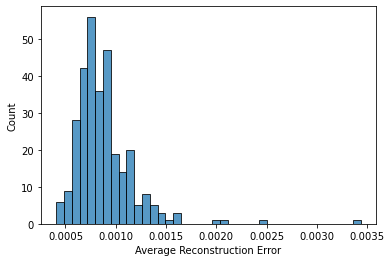

In [15]:
A = RE.reshape(20,-1,306).mean(axis=1)
df_opt_ae_4dim = pd.DataFrame(A[3], columns = ['Average Reconstruction Error'])
print(df_opt_ae_4dim)
sns.histplot(data=df_opt_ae_4dim, x='Average Reconstruction Error')

In [16]:
np.save('df_uiuc_ae_RE', A)
np.save('uiuc_ae_MSE_TEST', MSE_TEST)
np.save('uiuc_ae_MSE_TRAIN', MSE_TRAIN)
np.save('df_uiuc_ae_OUT_TRAIN', output)
np.save('df_uiuc_ae_OUT_TEST', output_y)

In [21]:
%%time

# PCA Parameters

num = 25
dim = 20
test_size = 0.2
train_size = (1-test_size)*1528
ts = 1528 - train_size
pca_MSE_TRAIN = np.zeros((dim,num), dtype=float)
pca_MSE_TEST = np.zeros((dim,num), dtype=float)
pca_RE = np.zeros((dim, num, math.ceil(ts)), dtype=float)
repro_test = np.zeros((dim, num, int(ts), 384), dtype=float)

for comp in range(1,dim+1):
    print(f'\n\nCOMPONENT NUMBER {comp}')
    for i in range(num):
        print(f'\n\nTRIAL NUMBER {i}')
        X_train, X_test = train_test_split(scaleddf, test_size=test_size, shuffle=True)
        pca = PCA(n_components = comp)
        dim = pca.fit_transform(X_train)
        reprojected = pca.inverse_transform(dim)
        xvals2 = list(range(comp))
        print()
        print(pca.explained_variance_ratio_)

        dim_test = pca.transform(X_test)
        repro_test = pca.inverse_transform(dim_test)
    
        MSEtrain = mean_squared_error(X_train, reprojected)
        MSEtest = mean_squared_error(X_test, repro_test)
   
        print(MSEtrain)
        print(MSEtest)

        pca_MSE_TRAIN[comp-1][i] = MSEtrain
        pca_MSE_TEST[comp-1][i] = MSEtest
        pca_RE[comp-1][i] = ((repro_test[comp-1][i] - X_test)**2).mean(axis=1)
    


print(f'MSE TRAIN: {pca_MSE_TRAIN}\n\nMSE TEST: {pca_MSE_TEST}\n\n')
print(f'MSE TRAIN MEAN: {pca_MSE_TRAIN.mean(axis=1)}\n\nMSE TEST MEAN: {pca_MSE_TEST.mean(axis=1)}\n\n')

B = pca_RE.reshape(20,-1,306).mean(axis=1)



COMPONENT NUMBER 1


TRIAL NUMBER 0

[0.42823717]
0.0051275247578270846
0.00523783624979067


TRIAL NUMBER 1

[0.4398176]
0.005122896885707316
0.005253219876701941


TRIAL NUMBER 2

[0.44036541]
0.005195508313787214
0.004966643774005686


TRIAL NUMBER 3

[0.44230235]
0.005103574691054737
0.005340582075814043


TRIAL NUMBER 4

[0.4447919]
0.005052496887743636
0.0055423087770103616


TRIAL NUMBER 5

[0.44493665]
0.0050846484412234725
0.005407151984141802


TRIAL NUMBER 6

[0.43873978]
0.00518723466005703
0.004997765291800614


TRIAL NUMBER 7

[0.43776339]
0.005156140436217517
0.005115286777333758


TRIAL NUMBER 8

[0.4368153]
0.005238670826907525
0.004786746849788904


TRIAL NUMBER 9

[0.44277309]
0.005039932648914521
0.0055905188770471875


TRIAL NUMBER 10

[0.44261629]
0.004938793749050004
0.006010795638247631


TRIAL NUMBER 11

[0.43269072]
0.005302884934259321
0.004547082218249741


TRIAL NUMBER 12

[0.43298688]
0.005095956444396113
0.005365048705372718


TRIAL NUMBER 13

[0.442769



TRIAL NUMBER 16

[0.43744556 0.24688355 0.1105511  0.08098959]
0.0011569129737735498
0.0010310826233377779


TRIAL NUMBER 17

[0.4426128  0.25220052 0.10287016 0.08309677]
0.0010868479938292428
0.001320785803127047


TRIAL NUMBER 18

[0.4538779  0.23826853 0.10734138 0.07961925]
0.0010806512837253828
0.0013595618770620571


TRIAL NUMBER 19

[0.43161666 0.24658415 0.11300722 0.08346391]
0.001165279028114613
0.0009952002370973302


TRIAL NUMBER 20

[0.44613965 0.24196812 0.11310682 0.07625326]
0.001121031939469458
0.0011809197018371497


TRIAL NUMBER 21

[0.44275497 0.25449492 0.10566225 0.07701311]
0.0010991224976940482
0.001279533702321124


TRIAL NUMBER 22

[0.44359415 0.24360147 0.10889085 0.07772177]
0.0011443356518847944
0.0010935330357262026


TRIAL NUMBER 23

[0.45505267 0.23527335 0.10493265 0.08221986]
0.0011120146948637134
0.0012163281854152865


TRIAL NUMBER 24

[0.43479754 0.24630569 0.10752573 0.08561825]
0.0011710899416542814
0.000972197092341518


COMPONENT NUMBER 5


T

0.0004809004943879469
0.0005365647067235407


TRIAL NUMBER 8

[0.44606923 0.25117041 0.10836819 0.07600057 0.02783755 0.02362277
 0.01510012]
0.0004685673540202185
0.0006171161356046353


TRIAL NUMBER 9

[0.43751653 0.24496058 0.11377117 0.07996113 0.02750934 0.024055
 0.019093  ]
0.0004941851043717618
0.0004694318723266041


TRIAL NUMBER 10

[0.43905975 0.24897974 0.10514145 0.08322995 0.02741114 0.02508672
 0.01818985]
0.00048758733864681046
0.0004907483526302808


TRIAL NUMBER 11

[0.42774525 0.24015945 0.11650603 0.08453671 0.0293279  0.02627229
 0.02056589]
0.0004885586362215576
0.00048328168477268935


TRIAL NUMBER 12

[0.44458054 0.25237876 0.10710652 0.07574563 0.0280656  0.02306131
 0.01662359]
0.00047399163446838885
0.0005758521971253917


TRIAL NUMBER 13

[0.43152144 0.25539849 0.10925696 0.0805154  0.02670431 0.02455147
 0.01815266]
0.000505661196633983
0.00041477036324180265


TRIAL NUMBER 14

[0.43617518 0.24874228 0.10816039 0.08406443 0.02771753 0.02504373
 0.01870047]




TRIAL NUMBER 13

[0.44555537 0.23839185 0.10377265 0.08579357 0.02885418 0.02543529
 0.01751325 0.01478648 0.01304966]
0.00023992407963163592
0.00027051734956231595


TRIAL NUMBER 14

[0.44376576 0.24857582 0.11026659 0.07566061 0.0286706  0.02350695
 0.01799932 0.01382701 0.01171777]
0.00023294277020307502
0.00031378338982872425


TRIAL NUMBER 15

[0.43694181 0.25812878 0.1117693  0.07298817 0.02823709 0.02419549
 0.01769079 0.01327131 0.01184849]
0.0002275730886839058
0.00033298329308906974


TRIAL NUMBER 16

[0.43573109 0.25156036 0.10780914 0.08070432 0.0281628  0.02476633
 0.01857942 0.01429042 0.01223113]
0.00024269696421909872
0.00025693417998277646


TRIAL NUMBER 17

[0.44331085 0.24282883 0.10592697 0.08239018 0.02875647 0.02452639
 0.01696325 0.0145911  0.01339218]
0.00024800886813515586
0.00024042680811562936


TRIAL NUMBER 18

[0.44434297 0.24229328 0.10621785 0.08446969 0.02690476 0.0251031
 0.01817222 0.01389985 0.01177904]
0.00024217661330513103
0.00026618263191404996


0.00015027145446079059
0.00018101804593418692


TRIAL NUMBER 10

[0.43230854 0.24684465 0.11147643 0.08248582 0.02744474 0.02567725
 0.01886552 0.01476472 0.01286003 0.00603572 0.00418947]
0.00015697340027784137
0.00014630945737129805


TRIAL NUMBER 11

[0.43789188 0.25385997 0.11109131 0.07519309 0.02794816 0.0239958
 0.01823388 0.01432369 0.0118811  0.00574481 0.00364155]
0.0001512949829159775
0.00018162378798248404


TRIAL NUMBER 12

[0.4412939  0.24035728 0.11081798 0.08099428 0.02915347 0.02536046
 0.01771526 0.01400722 0.01337663 0.00605506 0.00426568]
0.0001486241161841271
0.00018370615613767926


TRIAL NUMBER 13

[0.43639201 0.24982075 0.10642703 0.08373209 0.02764333 0.02517719
 0.01850636 0.01496793 0.01131625 0.00573508 0.00408645]
0.00014324194532381075
0.00020996282492442904


TRIAL NUMBER 14

[0.42555908 0.25083137 0.11571752 0.08181566 0.0283261  0.02490308
 0.01957217 0.01380192 0.01203957 0.00587038 0.00424804]
0.00016026703335940269
0.0001329702666175371


TRIAL NUMBE



TRIAL NUMBER 2

[0.44477991 0.25228578 0.10286022 0.07741131 0.02698122 0.02498918
 0.01801904 0.01409039 0.0116078  0.00558074 0.00422698 0.00308798
 0.00248231]
0.00010518953162566264
0.00010887215920592624


TRIAL NUMBER 3

[0.44476071 0.24890602 0.10697072 0.07940089 0.02812103 0.02321515
 0.01586808 0.01439786 0.01203007 0.00577927 0.00424571 0.00315272
 0.00220455]
9.918907954633721e-05
0.00014149560904902766


TRIAL NUMBER 4

[0.4291395  0.25215737 0.11222146 0.08222976 0.0281043  0.02527907
 0.01739997 0.01369452 0.0130101  0.00597469 0.00405235 0.00314905
 0.00232445]
0.00010507261863101126
0.00010487620233515829


TRIAL NUMBER 5

[0.43207636 0.25542241 0.11401824 0.07657847 0.02777923 0.02445047
 0.01896884 0.01319144 0.01169132 0.00549347 0.00350928 0.00315163
 0.0022741 ]
0.00010509844031319414
0.00010793254464530905


TRIAL NUMBER 6

[0.44718953 0.24834462 0.10905582 0.07699938 0.02782457 0.02337245
 0.01652046 0.01379968 0.01156527 0.00571031 0.00386593 0.00312888
 0.00

8.187897981022424e-05
0.00010667413005757276


TRIAL NUMBER 16

[0.4404978  0.24693123 0.10502485 0.08321367 0.02816324 0.02592719
 0.01748957 0.01439196 0.01212577 0.00559302 0.00416523 0.00297824
 0.0024946  0.00203319]
8.139153215127065e-05
0.00010760783107255931


TRIAL NUMBER 17

[0.4282465  0.25603372 0.10847481 0.08378606 0.02784058 0.02631498
 0.01742434 0.01358921 0.01190347 0.00605939 0.00355934 0.00315295
 0.00234522 0.00216162]
8.102486003753816e-05
0.00010960927533442846


TRIAL NUMBER 18

[0.42872011 0.24545478 0.11570962 0.08278711 0.02853526 0.02462841
 0.01944889 0.0138789  0.01312419 0.00608747 0.00428139 0.00308507
 0.00249674 0.00212659]
8.916325067445317e-05
7.26725507771822e-05


TRIAL NUMBER 19

[0.43317461 0.25194293 0.10813396 0.08191562 0.02772703 0.02470395
 0.01851679 0.01365542 0.01299424 0.00590291 0.00416806 0.00304397
 0.00239073 0.0020741 ]
8.767428773875565e-05
8.037562414558298e-05


TRIAL NUMBER 20

[0.4361372  0.24336086 0.10802063 0.08457502 0.0296

5.777936713269055e-05
6.294791983525651e-05


TRIAL NUMBER 4

[0.44548487 0.24620231 0.10665037 0.08332475 0.02733691 0.02446571
 0.01469323 0.01278127 0.0119626  0.00594548 0.00420934 0.00299043
 0.0024337  0.00213888 0.00176337 0.00131973]
5.60521443132002e-05
7.524493585638329e-05


TRIAL NUMBER 5

[0.42747803 0.25323105 0.1101352  0.08349189 0.02745423 0.02515351
 0.01904241 0.01460603 0.0126741  0.00576622 0.00425833 0.00306643
 0.00250198 0.00200585 0.00162971 0.00116596]
5.94794281665056e-05
5.687864704088868e-05


TRIAL NUMBER 6

[0.45713453 0.2318984  0.10546884 0.08047603 0.02687205 0.02481175
 0.01912896 0.01438615 0.01275739 0.00596273 0.00443487 0.0029562
 0.00242592 0.00200986 0.00165244 0.00128246]
5.7200385145732555e-05
6.462509992686267e-05


TRIAL NUMBER 7

[0.44594244 0.2479305  0.1060904  0.0811409  0.02682279 0.02307238
 0.01659495 0.01426769 0.01164685 0.0059846  0.00423137 0.00310766
 0.00223527 0.00201047 0.00162802 0.00129847]
5.405931975313691e-05
8.5788259666



TRIAL NUMBER 12

[0.43940937 0.25086108 0.10755234 0.08071697 0.02721251 0.02324871
 0.01788581 0.01372348 0.01267313 0.00614124 0.004067   0.00297369
 0.00232716 0.00206332 0.00169667 0.0013172  0.00087529]
4.860469465170362e-05
5.387847315606241e-05


TRIAL NUMBER 13

[0.44559684 0.2494357  0.09905652 0.08265412 0.02700054 0.02501619
 0.01735061 0.01483254 0.01232915 0.00589323 0.00402454 0.00304416
 0.00243041 0.00197036 0.00159733 0.00128296 0.00101986]
5.003134688578596e-05
5.165588866230588e-05


TRIAL NUMBER 14

[0.4531485  0.23815911 0.10621581 0.08272753 0.02818714 0.02509673
 0.01520837 0.01318123 0.01251414 0.00583389 0.00367784 0.0030391
 0.00222172 0.00207638 0.00168895 0.00124234 0.00084989]
4.3956970450609904e-05
7.892559732369277e-05


TRIAL NUMBER 15

[0.43049431 0.25639655 0.11390334 0.07883195 0.0270405  0.0246584
 0.01654626 0.01398811 0.01206404 0.00540941 0.00407043 0.00311753
 0.00244878 0.00201423 0.00172184 0.0012401  0.00089696]
4.668169012730317e-05
6.47124


[0.42722422 0.25985846 0.1150416  0.07258787 0.02904032 0.02445953
 0.01774157 0.01466607 0.01285385 0.00608125 0.00435203 0.00310906
 0.00223469 0.00203576 0.00172082 0.00109675 0.00090283 0.00070161]
3.877767495061186e-05
7.602202625627188e-05


TRIAL NUMBER 21

[0.44245746 0.2445402  0.10717132 0.08138738 0.02907823 0.02511014
 0.01566091 0.0148058  0.0129641  0.00578659 0.0043521  0.00302322
 0.00259383 0.00212589 0.00174668 0.00128012 0.00090964 0.00072433]
3.851950758880371e-05
6.823825786398447e-05


TRIAL NUMBER 22

[0.42762884 0.25426269 0.11049612 0.08224344 0.0283599  0.02443111
 0.01911776 0.01339387 0.01276104 0.0059488  0.00438797 0.00308924
 0.00238382 0.00215061 0.00170032 0.00126043 0.00102435 0.00069265]
4.370599346714035e-05
4.0993724405487336e-05


TRIAL NUMBER 23

[0.42915118 0.24880238 0.1116643  0.08498796 0.02841886 0.02479792
 0.01802425 0.01389819 0.01276453 0.00595897 0.00422215 0.00322444
 0.00241262 0.00209517 0.0017368  0.00126788 0.00106839 0.00073068]
4


[0.4490361  0.24291763 0.10375016 0.08207175 0.02750679 0.02532916
 0.01735563 0.01456337 0.01152922 0.0058004  0.0042014  0.00280129
 0.00250836 0.00188882 0.00164305 0.00127803 0.00079986 0.00068653
 0.0006359  0.00055056]
2.851812673107823e-05
4.50324864570398e-05


TRIAL NUMBER 1

[0.4257539  0.25135412 0.11300985 0.08264967 0.0284197  0.02540053
 0.01925403 0.01464355 0.01314567 0.0059386  0.00367407 0.00314196
 0.00232173 0.00207671 0.00179152 0.00114517 0.00098075 0.00069967
 0.00068856 0.00059449]
3.1075665266504974e-05
3.255785992267627e-05


TRIAL NUMBER 2

[0.43358706 0.2513686  0.11021366 0.08300254 0.02744449 0.02413667
 0.017589   0.01383684 0.01213993 0.00586492 0.00387361 0.00312398
 0.0024456  0.00201133 0.00160983 0.00129539 0.00106085 0.00069042
 0.00065474 0.00060199]
3.167773581078781e-05
2.9569451191659065e-05


TRIAL NUMBER 3

[0.44282011 0.25139719 0.10040509 0.08075052 0.02818167 0.02493983
 0.01751428 0.01435574 0.01213425 0.00608515 0.00444251 0.00309969
 0.


Wall time: 35.3 s


In [22]:
np.save('df_uiuc_pca_RE', B)
np.save('uiuc_pca_MSE_TEST', pca_MSE_TEST)
np.save('uiuc_pca_MSE_TRAIN', pca_MSE_TRAIN)
